# Search Engine Marketing optimization on RPC
- Aim to optimize Revenue per click (RPC) from a proper model, with index
$$\frac{1}{C} \sum^N_{i=1} \left[ c_i (r_i - \hat{r}_i)\right]$$

- Features: Date, Account, Campaign, Ad group, Keyword, Match type
- Potential Outputs: Revenue, Clicks, Conversion


## Outline
We would proceed our analysis starting from data analysis on different feature transformation, and find proper explanation from raw dataset. From our the findings, we would construct a 2-Stage model based on the extracted information. The process is stated below,
1. Identify Daily trend from Account, Device and Match type level
2. Identify Revenue, CR from different features
3. Identify Correlation between features and Revenue
4. 2-Stage Model construction example: Random Forest + Regression
5. Summary

At the beginning, I would treat every row (entry) in raw dataset as an independent example, each with 6 categorical features (Keyword_ID, Ad_group_ID, Campaign_ID, Account_ID, Device_ID, Match_type_ID) and Date as additional feature for advanced analysis. Our possible model is aimed to predict the Revenue, which would be a model predicting from categorical features to metrics value (Revenue).

In [1]:
#load lib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
from sklearn.naive_bayes import MultinomialNB
from sklearn import cross_validation
from sklearn import svm
%matplotlib inline

#Loading the prediction/train data as pred/train
pred = pd.read_csv('path\prediction.csv')
train = pd.read_csv('path\train.csv')

C:\Users\jncinlee\AppData\Local\Enthought\Canopy\User\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


However, after close inspectation, we have some insights on the raw input file. The entries of Revenue feature are mostly "0", where 8124774(98%) out of total 8285423 entries are "0". Moreover, there are examples with Conversions number larger than Clicks number. It is not reasonable for certain "Keyword" with only 2 Clicks but generating 1180 Conversions.

Therefore, we could assume the raw input file as transaction log file, which needs a further transformation and aggregation that we could have more meaningful interpretation.

In [3]:
print 'Number of total row:', train.Revenue.count() ,', Number row where Rev equals "0":', train.Revenue[train.Revenue==0].count()
train[train.Conversions > train.Clicks].sort_values(by = 'Revenue', ascending = False).head()

Number of total row: 8285423 , Number row where Rev equals "0": 8124774


,Date,Keyword_ID,Ad_group_ID,Campaign_ID,Account_ID,Device_ID,Match_type_ID,Revenue,Clicks,Conversions
5811919,2015-02-10,880675760669,699641057880,590366876673,604905316813,298643508640,95725474456,1029647.26,2,1180
4208013,2015-03-15,122784991467,667966093283,366894139959,212779990172,298643508640,894413617560,515531.80,5,53
1794599,2015-01-31,664950937110,203625386298,733188841810,604905316813,298643508640,95725474456,392004.96,2,8
1031683,2015-03-31,423751278725,222173038756,321559281060,719583196582,848779586902,872544605608,391180.26,2,153
985996,2015-03-19,358066181977,322628394005,722064922082,573604300663,298643508640,95725474456,348468.78,2,11


## 1-1. Identify Daily Trend of Account_ID in Summarized Pivot Table
We will first aggregate Revenue, Clicks, Conversions by Date and Account_ID. The Date range for the raw data is from 2014-12-14 to 2015-04-07 with 115 days and 16 different Account_ID in total.

I would introduce a new Conversion rate (CR) index for combining Clicks and Conversion information for each day. The popular CR index is defined as below,
$$ CR = \frac{Conversion}{Clicks} $$

In [4]:
DateAcc = train.pivot_table(index = ['Date'],columns=['Account_ID'], values=['Revenue','Clicks','Conversions'], aggfunc=np.sum) #, margins=True)
DateAcc_CR = DateAcc['Conversions']/(DateAcc['Clicks']+10**-10)
#DateAcc_Rev = DateAcc.Revenue
#DateAcc = pd.concat([DateAcc,DateAcc_CR],axis=1)

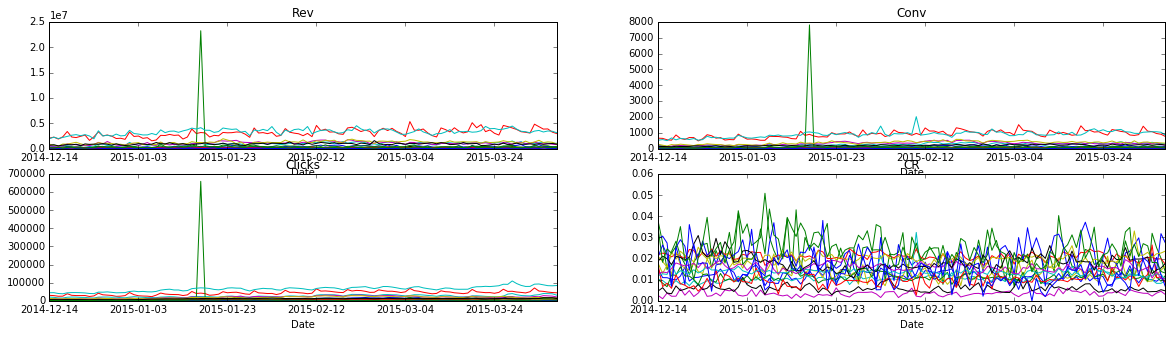

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(20, 5))
DateAcc.Revenue.plot(rot=0, ax=axes[0,0], title='Rev', legend=False)
DateAcc.Conversions.plot(rot=0, ax=axes[0,1], title='Conv', legend=False)
DateAcc.Clicks.plot(rot=0, ax=axes[1,0], title='Clicks', legend=False)
DateAcc_CR.plot(rot=0, ax=axes[1,1], title='CR', legend=False)
plt.show()

At this place, we could observe a obvious outlier at the Date 2015-01-17 from Account_ID=575525143937. The Revenue surges to $23,236,230, which is 4.2 times compares to maximum Revenue from other Account in this period. 
However, we will keep the outlier in the analysis. Since daily trend in Conversions and Clicks also boosts in the same date, and the CR maintains at the same level in this period. We could not judge if it is from marketing promotion or system error.

The top Account are with ID 604905316813 and 212779990172, which generate \$382 million and \$358 million respectively. That is 2.5 times to other accounts. We would thus consider Account_ID as influential factor.

Another major finding in the daily trend is the fluctuation of weekly circle. We could observe a peak Revenue for every 7 day, for example on 2015-01-12 on Account_ID=212779990172 and every Thursday. When finding special features in our model, we should consider the effect of weekday to Revenue, or to level out the effect on different weekdays.

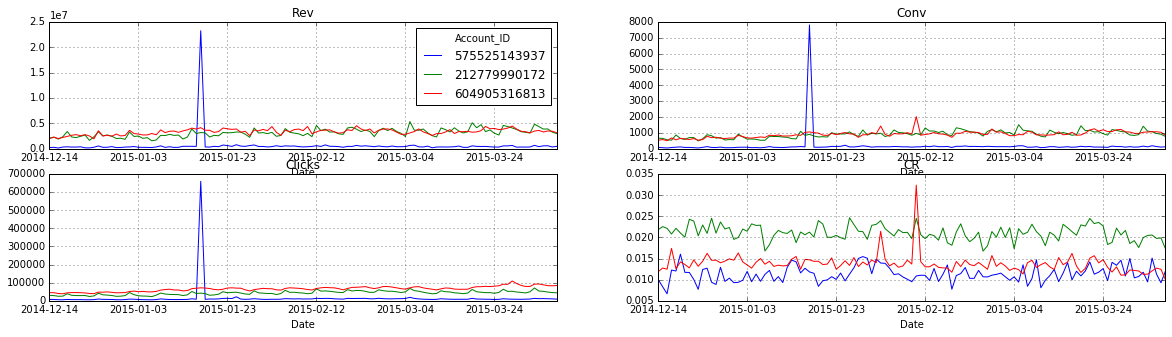

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(20, 5))
DateAcc.Revenue[[575525143937, 212779990172, 604905316813]].plot(rot=0, ax=axes[0,0], grid=True, title='Rev') #outlier 575525143937, 212779990172
DateAcc.Conversions[[575525143937, 212779990172, 604905316813]].plot(rot=0, ax=axes[0,1], grid=True, title='Conv', legend=False)
DateAcc.Clicks[[575525143937, 212779990172, 604905316813]].plot(rot=0, ax=axes[1,0], grid=True, title='Clicks', legend=False)
DateAcc_CR[[575525143937, 212779990172, 604905316813]].plot(rot=0, ax=axes[1,1], grid=True, title='CR', legend=False)
plt.show()

#DateAcc.Revenue.plot(subplots=True, figsize=(12, 10), grid=True, title="Number of Rev. per account")

## 1-2. Identify Daily Trend of Device_ID, Match_type_ID in Summarized Pivot Table  
We will briefly inspect the daily trend from different Device_ID and Match_type_ID. Since both are feature with 3 categories, we could visualize the daily trend plot easily.

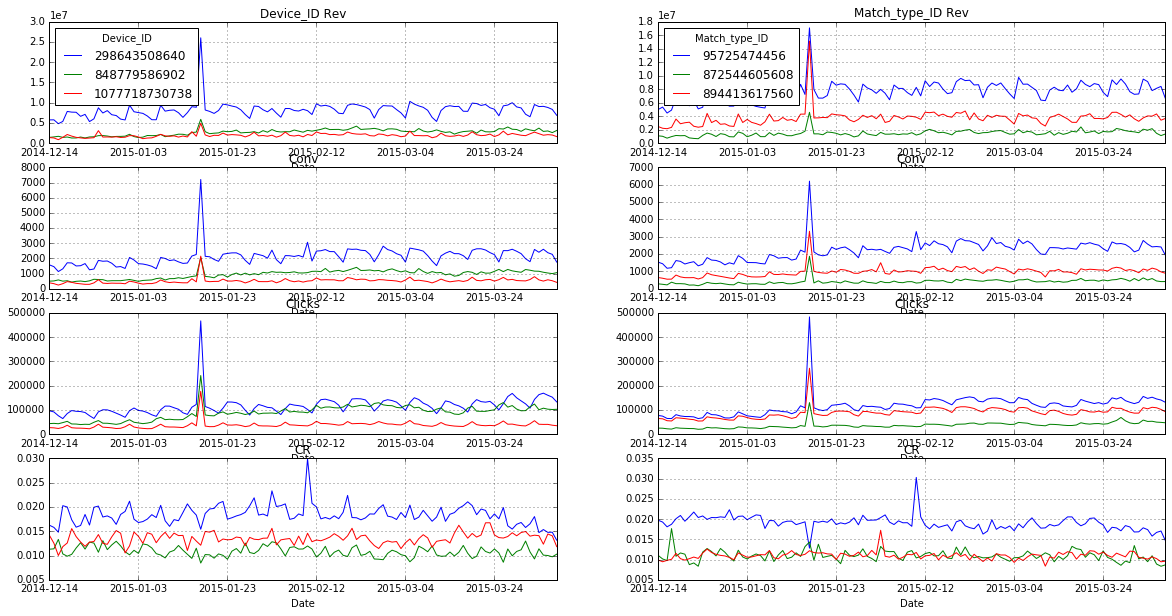

In [19]:
DateDev = train.pivot_table(index = ['Date'],columns=['Device_ID'], values=['Revenue','Clicks','Conversions'], aggfunc=np.sum) #, margins=True)
DateDev_CR = DateDev['Conversions']/(DateDev['Clicks']+10**-10)

DateMat = train.pivot_table(index = ['Date'],columns=['Match_type_ID'], values=['Revenue','Clicks','Conversions'], aggfunc=np.sum) #, margins=True)
DateMat_CR = DateMat['Conversions']/(DateMat['Clicks']+10**-10)

fig, axes = plt.subplots(4, 2, figsize=(20, 10))
DateDev.Revenue.plot(rot=0, ax=axes[0,0], grid=True, title='Device_ID Rev') 
DateDev.Conversions.plot(rot=0, ax=axes[1,0], grid=True, title='Conv', legend=False)
DateDev.Clicks.plot(rot=0, ax=axes[2,0], grid=True, title='Clicks', legend=False)
DateDev_CR.plot(rot=0, ax=axes[3,0], grid=True, title='CR', legend=False)
DateMat.Revenue.plot(rot=0, ax=axes[0,1], grid=True, title='Match_type_ID Rev') 
DateMat.Conversions.plot(rot=0, ax=axes[1,1], grid=True, title='Conv', legend=False)
DateMat.Clicks.plot(rot=0, ax=axes[2,1], grid=True, title='Clicks', legend=False)
DateMat_CR.plot(rot=0, ax=axes[3,1], grid=True, title='CR', legend=False)
plt.show()

In above figures, we could find both Device and Match_type features having effects on generating Revenue. Device_ID=298643508640 is generating 3 times Revenue than other two devices on daily basis. Match_type_ID=95725474456 generates 2-4 times Revenue than other searching match type. This suggests us to buying more click volume on this matching type,
             
We would consider the Account_ID, Device_ID, Match_type_ID in our future model. As on daily trend analysis, all three features show a significant impact on generating higher Revenue. However, we would limit our daily trend analysis to these features, while features like Campaign_ID, Ad_group_ID and Keyword_ID have more than 3 outcomes. Plots with more than 3 outcomes will be not easy for human eye interpretation (as below Campaign level daily trend, the daily trend are covering each other).

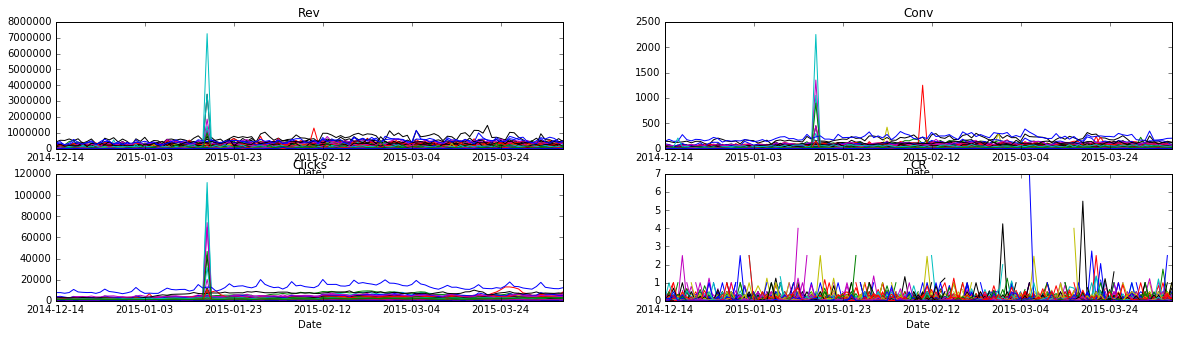

In [32]:
DateCam = train.pivot_table(index = ['Date'],columns=['Campaign_ID'], values=['Revenue','Clicks','Conversions'], aggfunc=np.sum)
DateCam_CR = DateCam['Conversions']/(DateCam['Clicks']+10**-10)

fig, axes = plt.subplots(2, 2, figsize=(20, 5))
DateCam.Revenue.plot(rot=0, ax=axes[0,0], title='Rev', legend=False)
DateCam.Conversions.plot(rot=0, ax=axes[0,1], title='Conv', legend=False)
DateCam.Clicks.plot(rot=0, ax=axes[1,0], title='Clicks', legend=False)
DateCam_CR.plot(rot=0, ax=axes[1,1], title='CR', legend=False)
plt.show()

## 2. Identify Revenue, CR Distribution of Account_ID, Campaign_ID, Ad_group_ID, Keyword_ID from Summarized Pivot Table 
In another aspect of view, we will approach from Account_ID, Campaign_ID, Ad_group_ID and Keyword_ID and analyze its effect on generating Revenue.

In [2]:
#Keyword_ID Ad_group_ID Campaign_ID Account_ID Device_ID
AccRCC = train.pivot_table(index=['Account_ID'], values=['Revenue', 'Conversions', 'Clicks'], aggfunc=np.sum) #, margins=True)
CamRCC = train.pivot_table(index=['Campaign_ID'], values=['Revenue', 'Conversions', 'Clicks'], aggfunc=np.sum) #, margins=True)
AdgpRCC = train.pivot_table(index=['Ad_group_ID'], values=['Revenue', 'Conversions', 'Clicks'], aggfunc=np.sum) #, margins=True)
KwsRCC = train.pivot_table(index=['Keyword_ID'], values=['Revenue', 'Conversions', 'Clicks'], aggfunc=np.sum) #, margins=True)

AccRCC_CR = AccRCC['Conversions']/(AccRCC['Clicks']+10**-10)
CamRCC_CR = CamRCC['Conversions']/(CamRCC['Clicks']+10**-10)
AdgpRCC_CR = AdgpRCC['Conversions']/(AdgpRCC['Clicks']+10**-10)
KwsRCC_CR = KwsRCC['Conversions']/(KwsRCC['Clicks']+10**-10)

#Keyword_ID Ad_group_ID combination
ACAK_RCC = train.pivot_table(index=['Keyword_ID'], values=['Revenue', 'Conversions', 'Clicks'], aggfunc=np.sum) #, margins=True)
ACAK_RCC_CR = ACAK_RCC['Conversions']/(ACAK_RCC['Clicks']+10**-10)

Information of Revenue against Account_ID, Campaign_ID, Ad_group_ID and Keyword_ID is collecting in below barplot. We would also summarize Conversions and Clicks by Conversion rate (CR).

From first row of barchart for Revenue/CR vs. Account level, we could identify Account_ID=604905316813 generates the most Revenue in comparison to other accounts. However, the information conveying is more blurred on lower hierachy Revenue/CR vs. Campaign level. We could barely identify the Campaign_ID=8380016917 generating the most Revenue. 

As in even lower hierachy like Ad group or Keyword, the information is more fuzzy as Revenue distributed to 270,000 possible cells of Ad group, and to 490,000 possible Keywords. In one campaign, we replicate same Keywords into different Ad groups. The actual combination of Ad group and Keyword will be 1,052,000, which means distributing our total Revenue to 1 million possible results.

Account_ID vs. Revenue, CR


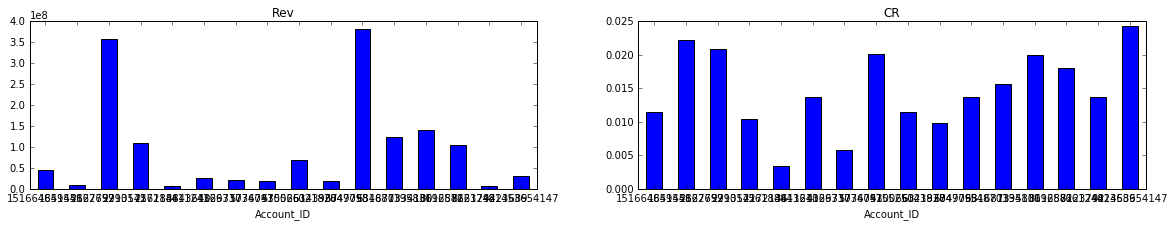

Campaign_ID vs. Revenue, CR


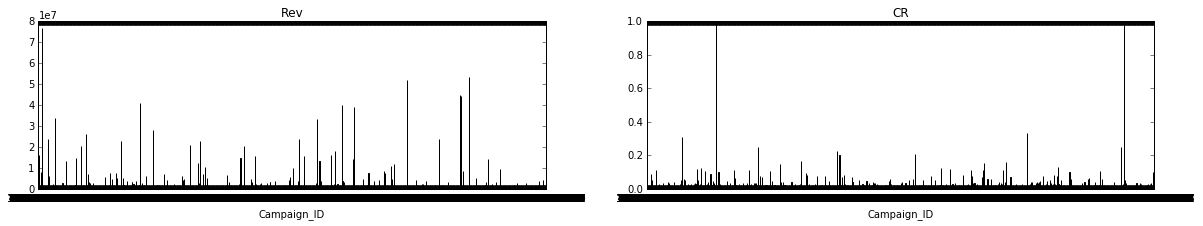

In [3]:
print 'Account_ID vs. Revenue, CR'
fig, axes = plt.subplots(1, 2, figsize=(20, 3))
AccRCC.Revenue.plot(kind='bar', rot=0, ax=axes[0], title='Rev') 
AccRCC_CR.plot(kind='bar', rot=0, ax=axes[1], title='CR', legend=False)
plt.show()

print 'Campaign_ID vs. Revenue, CR'
fig, axes = plt.subplots(1, 2, figsize=(20, 3))
CamRCC.Revenue.plot(kind='bar', rot=0, ax=axes[0], title='Rev') 
CamRCC_CR.plot(kind='bar', rot=0, ax=axes[1], title='CR', legend=False)
plt.show()


## 3. Identify Critical Features from Correlation
After visualization, we would identify the relation between Features (from Account to Match type level) and Revenue by certain KPI. We first construct pivot table summing Revenue from all feature level, and find out the relation bewteen Revenue to each feature level by correlation.

In [2]:
#Keyword_ID Ad_group_ID Campaign_ID Account_ID Device_ID Match_type_ID
AllRev = train.pivot_table(index=['Account_ID','Campaign_ID','Ad_group_ID','Keyword_ID','Device_ID','Match_type_ID'], 
                           values=['Revenue'], aggfunc=np.sum) 
#for getting the index as part of feature table lol, output then input again
AllRev.to_csv('path\AllRev.csv')

#Reload the table containing level information, and define lable with 1 when Revenue > $0, label 0 when Revenue=$0
All_Rev = pd.read_csv('path\AllRev.csv')
All_Rev_Label = [All_Rev.Revenue>0]*1 + [All_Rev.Revenue==0]*0
All_Rev_Label = np.asarray(All_Rev_Label).ravel()

We could find the correlation of each feature on last column of Revenue. Device_ID and Match_type_ID are more correlated to Revenue than other features. However, the absolute value in correlation matrix is small. This is obviously affected by zero Revenue cells, which occupying 98% of the Revenue column, and leveling out the correlation.

In [9]:
All_Rev.corr()

,Account_ID,Campaign_ID,Ad_group_ID,Keyword_ID,Device_ID,Match_type_ID,Revenue
Account_ID,1.000000,0.090115,-0.001763,-0.001132,0.011111,0.004315,-0.001817
Campaign_ID,0.090115,1.000000,-0.005635,-0.000520,0.005418,-0.005598,-0.003578
Ad_group_ID,-0.001763,-0.005635,1.000000,0.000007,-0.000085,0.000942,0.001698
Keyword_ID,-0.001132,-0.000520,0.000007,1.000000,-0.000249,-0.000229,-0.002467
Device_ID,0.011111,0.005418,-0.000085,-0.000249,1.000000,-0.012231,-0.011748
Match_type_ID,0.004315,-0.005598,0.000942,-0.000229,-0.012231,1.000000,-0.010227
Revenue,-0.001817,-0.003578,0.001698,-0.002467,-0.011748,-0.010227,1.000000


From this, we would construct a desired model for predicting Revenue, a 2-stage ensemble model. First stage of the model would be a classification model, aiming to classify feature combination that generating Revenue (Revenue > 0) and not generating Revenue (Revenue = 0) from summarized pivot table. The second stage of model would predict Revenue from selected features.

## 4. Develop 2-stage Ensemble Model
We would develop our model from the summarized pivot table, which containing the sum of Revenue based on Account_ID, Campaign_ID, Ad_group_ID, Keyword_ID,  Device_ID and Match_type_ID levels. The 2-stage ensemble model could be illustrated as below figure,

<img src="https://raw.githubusercontent.com/jncinlee/Project_SEM_model/master/1.png">

The model in stage-1 could be various classification methods, like: Naive Bayes, Logistic Regression, SVM or Random Forest. We will separate 2% examples that generating Revenue from other 98% examples, then proceed on constructing Revenue prediction model in stage-2. 

We could apply Regression model in stage-2, for it has largely narrow down the number of categories in each feature. We could also apply clustering model in stage-2 to classify feature into different pre-defined Revenue groups (eg. Revenue groups: \$1~\$1000, \$1001~\$2000,...).

When constructing models, we could proceed the feature selection at the same time, recognizing the correlation between features and Revenue compared to above KPIs. This will largely enhance the Revenue prediction accuracy in the long run.

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

#Transformation
All_Rev['Account_ID_c'] = pd.Categorical(All_Rev.Account_ID).codes
All_Rev['Campaign_ID_c'] = pd.Categorical(All_Rev.Campaign_ID).codes
All_Rev['Ad_group_ID_c'] = pd.Categorical(All_Rev.Ad_group_ID).codes
All_Rev['Keyword_ID_c'] = pd.Categorical(All_Rev.Keyword_ID).codes
All_Rev['Device_ID_c'] = pd.Categorical(All_Rev.Device_ID).codes
All_Rev['Match_type_ID_c'] = pd.Categorical(All_Rev.Match_type_ID).codes

#Select features
X = All_Rev[['Account_ID_c','Campaign_ID_c','Ad_group_ID_c','Keyword_ID_c','Match_type_ID_c','Device_ID_c']]
y = All_Rev_Label

#########choose from Random Forest, Naive Bayes, Decision Tree#########
clf = RandomForestClassifier(n_estimators=10)
#clf = tree.DecisionTreeClassifier()
#clf = MultinomialNB()

clf = clf.fit(X, y)
p = clf.predict(X)
print 'The number predict as (Rev > 0):', p.sum()

The number predict as (Rev > 0): 70261


In [20]:
#Divid train dataset as 70% train/ 30% test
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

#########choose from Random Forest, Naive Bayes, Decision Tree#########
clf = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
#clf = MultinomialNB().fit(X_train, y_train)
#clf = tree.DecisionTreeClassifier().fit(X_train, y_train)

#5-fold cross validation model
scores = cross_validation.cross_val_score(clf, X, y, cv=5)
print 'The average accuracy for 5-fold CV on Classifier:', scores.mean()

The average accuracy for 5-fold CV on Random Forest Classifier: 0.601425643131


We proceed with a short demonstration on Random Forest Classifier as Stage-1 model, the average accuracy for 5-fold cross validation is 0.601. Although the result from NB classifier is not too satifying, we could further modify the Stage-1 model, and fined-tune its performance accordingly. We could also try on other model combination that best fit for categorical feature classification.

In [23]:
#Mulitivariate Regression
import statsmodels.api as sm

#Select features
X = All_Rev[p][['Account_ID_c','Campaign_ID_c','Ad_group_ID_c','Keyword_ID_c','Device_ID_c','Match_type_ID_c']]
y = All_Rev[p][['Revenue']]

X1 = sm.add_constant(X)
est = sm.OLS(y, X1).fit()

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Revenue   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     23.17
Date:                Thu, 09 Mar 2017   Prob (F-statistic):           3.66e-19
Time:                        22:41:00   Log-Likelihood:            -9.3070e+05
No. Observations:               70261   AIC:                         1.861e+06
Df Residuals:                   70256   BIC:                         1.861e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const            2.903e+04   1489.360     19.495      0.000      2.61e+04   3.2e+04
Campaign_ID_c      -2.7835      0.610     -4.565      0.000        -3.978    -1.588
Keyword_ID_c       -0.0122      0.004     -3.323      0.001        -0.019    -0.005
Device_ID_c     -4469.4359    674.422     -6.627      0.000     -5791.302 -3147.570
Match_type_ID_c -2487.4872    575.875     -4.319      0.000     -3616.201 -1358.773
==============================================================================
Omnibus:                   297787.480   Durbin-Watson:                   1.518
Prob(Omnibus):                  0.000   Jarque-Bera (JB):    1139557915085.070
Skew:                         123.212   Prob(JB):                         0.00
Kurtosis:                   19730.987   Cond. No.                     8.27e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Applying regression as stage 2 model, we could further predict the value of Revenue based on this. From output above, we have excluding features "Account_ID" and "Ad_group_ID" in the prediction model for no significance.

## 5. Summary
- By feature transformation, we have successfully reduced the dimension from origin log datasets with 8.3 million entries to summarized pivot table with 1.8 million entries. 

- We further select informative entries for Revenue prediction from the Stage 1 model, the example on Random Forest reduced the size of dataset to 70261 entries with 0.6 accuracy.

- By appropriate feature transformation and selection, we could construct a 2-stage ensemble model for predicting Revenue accurately. We could do experiments on different model, and validate the performance for best prediction.

- We could furhter consider "Date" in feature transformation. The Daily trend from different Account, Device and Match type have obvious impact on generating Revenue. We could consider Time Series model for monitoring the search engine marketing.

- In the analysis, we treat "Conversion" and "Clicks" as output variable. However, we could apply it in 2-Stage model for prediction of Revenue, and extend model from thses additional information.